In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../')
import paths_vsn17 as pth
import crosswalk as cwlk
import mrtool
import crosswalk_functions

In [3]:
param_estimate_df = pd.DataFrame({'draw': np.arange(1000)})
param_summary_df = pd.DataFrame({v: [] for v in ['beta', 'se_beta']},
                                index=[])

In [4]:
df = pd.read_csv(pth.PAIRED_CWALK_DF)

In [8]:
df = df.loc[df['sens_vars'].notnull()]

# Vaccine Cost

In [10]:
vacc_cost_df = df[df['sens_vars'].isin(['vaccine_total_cost'])].copy()

non_na_cols = ['log_icer_sens', 'log_icer_ref', 'log_vaccine_cost_2017usd_sens', 'log_vaccine_cost_2017usd_ref']
vacc_cost_df = vacc_cost_df.loc[vacc_cost_df[non_na_cols].notnull().all(axis=1)].copy()
vacc_cost_df = vacc_cost_df.loc[~np.isinf(vacc_cost_df[non_na_cols]).any(axis=1)].copy()

In [11]:
vacc_cost_df = crosswalk_functions.create_diff_variables(
    vacc_cost_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='log_vaccine_cost_2017usd')

In [12]:
cwalk_rids = set(list(vacc_cost_df['RatioID'].unique()) + list(vacc_cost_df['reference_scenario']))

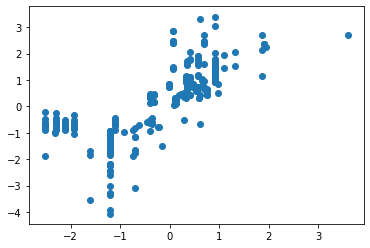

In [16]:
plt.scatter(x=vacc_cost_df['log_vaccine_cost_2017usd_diff'].to_numpy(),
            y=vacc_cost_df['log_icer_diff'].to_numpy(),
           )

In [17]:
vacc_cost_df['clr'] = (vacc_cost_df['log_icer_diff'].between(-1.2, 0)) & (vacc_cost_df['log_vaccine_cost_2017usd_diff'] < -1.7)

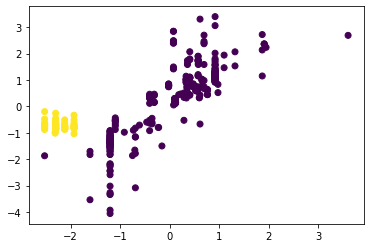

In [18]:
plt.scatter(x=vacc_cost_df['log_vaccine_cost_2017usd_diff'].to_numpy(),
            y=vacc_cost_df['log_icer_diff'].to_numpy(),
            c=vacc_cost_df['clr'].to_numpy()
           )

In [ ]:
x = pd.read_csv(pth.SENS_ANLYS_DF)

In [21]:
vacc_cost_df = vacc_cost_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)

In [22]:
vacc_cost_df = vacc_cost_df.loc[vacc_cost_df['log_icer_diff'].notnull()]

In [23]:
mr = crosswalk_functions.cwalk(vacc_cost_df, 'log_icer', 'log_icer_se', 'log_vaccine_cost_2017usd', 'ArticleID')

In [ ]:
mr.beta_soln

In [ ]:
vacc_cost_beta_samples, vacc_cost_summary = crosswalk_functions.summarize_cwalk(mr, 'log_vacc_cost')

In [ ]:
crosswalk_functions.compare_sd_versions(mr, beta_samples=vacc_cost_beta_samples)

In [28]:
param_estimate_df['log_vaccine_cost'] = vacc_cost_beta_samples

In [29]:
param_summary_df = pd.concat([param_summary_df,
                              vacc_cost_summary],
                             axis=0)

# Q/DALYs Discount Rate

In [31]:
bdr_df = df[df['sens_vars'] == 'DiscountRate'].copy()
bdr_df['burden_disc_rate_sens'] = df['DiscountRate_sens']
bdr_df['burden_disc_rate_ref'] = df['DiscountRate_ref']
bdr_df = bdr_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)
bdr_df[['log_icer_sens', 'log_icer_ref', 'log_icer_se_sens', 'burden_disc_rate_sens',
        'log_icer_se_ref', 'burden_disc_rate_ref', 'ArticleID']].isnull().sum(axis=1).sum()

4

In [32]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'burden_disc_rate_sens', 'burden_disc_rate_ref']
bdr_df = bdr_df.loc[bdr_df[non_na_cols].notnull().all(axis=1)].copy()
bdr_df = bdr_df.loc[~np.isinf(bdr_df[non_na_cols]).any(axis=1)].copy()

In [33]:
bdr_df = crosswalk_functions.create_diff_variables(
    bdr_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='burden_disc_rate')

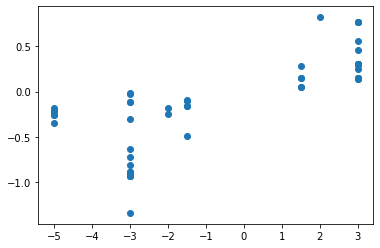

In [35]:
plt.scatter(x=bdr_df['burden_disc_rate_diff'].to_numpy(),
            y=bdr_df['log_icer_diff'].to_numpy(),
           )

In [36]:
bdr_mr = crosswalk_functions.cwalk(bdr_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='burden_disc_rate', study_id='ArticleID')

In [ ]:
bdr_mr.beta_soln

In [ ]:
bdr_mr.data.obs.shape

In [ ]:
bdr_beta_samples, bdr_summary = crosswalk_functions.summarize_cwalk(bdr_mr, 'burden_disc_rate')

In [ ]:
crosswalk_functions.compare_sd_versions(bdr_mr, beta_samples=bdr_beta_samples)

In [41]:
param_estimate_df['burden_disc_rate'] = bdr_beta_samples

In [42]:
param_summary_df = pd.concat([param_summary_df,
                              bdr_summary],
                             axis=0)

# Cost discount rate

In [44]:
cdr_df = df.loc[df['sens_vars'].isin(['CostDiscountRate', 'CostsDiscountRate'])].copy()

In [46]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'CostsDiscountRate_sens', 'CostsDiscountRate_ref']
cdr_df = cdr_df.loc[cdr_df[non_na_cols].notnull().all(axis=1)].copy()
cdr_df = cdr_df.loc[~np.isinf(cdr_df[non_na_cols]).any(axis=1)].copy()

In [47]:
cdr_df['cost_disc_rate_sens'] = cdr_df['CostsDiscountRate_sens']
cdr_df['cost_disc_rate_ref'] = cdr_df['CostsDiscountRate_ref']
cdr_df = crosswalk_functions.create_diff_variables(
    cdr_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='cost_disc_rate')

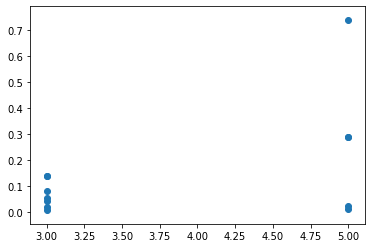

In [49]:
plt.scatter(x=cdr_df['cost_disc_rate_diff'].to_numpy(),
            y=cdr_df['log_icer_diff'].to_numpy(),
           )

In [51]:
cdr_df = cdr_df.drop('ArticleID_ref', axis=1).rename({'ArticleID_sens': 'ArticleID'}, axis=1)

In [52]:
cdr_mr = crosswalk_functions.cwalk(cdr_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='cost_disc_rate', study_id='ArticleID')

In [ ]:
cdr_mr.beta_soln

In [ ]:
cdr_beta_samples, cdr_summary = crosswalk_functions.summarize_cwalk(cdr_mr, 'cost_disc_rate')

In [ ]:
crosswalk_functions.compare_sd_versions(cdr_mr, beta_samples=cdr_beta_samples)

In [56]:
param_estimate_df['cost_disc_rate'] = cdr_beta_samples

In [57]:
param_summary_df = pd.concat([param_summary_df,
                              cdr_summary],
                             axis=0)

## Coverage

In [59]:
cvg_df = df[df['sens_vars'] == 'coverage'].copy()

In [60]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'coverage_sens', 'coverage_ref']
cvg_df = cvg_df.loc[cvg_df[non_na_cols].notnull().all(axis=1)].copy()
cvg_df = cvg_df.loc[~np.isinf(cvg_df[non_na_cols]).any(axis=1)].copy()

In [61]:
cvg_df = crosswalk_functions.create_diff_variables(
    cvg_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='coverage')

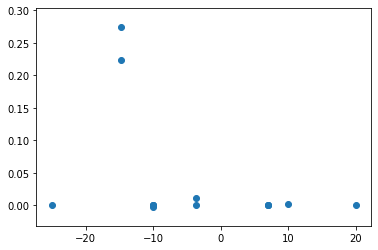

In [63]:
plt.scatter(x=cvg_df['coverage_diff'].to_numpy(),
            y=cvg_df['log_icer_diff'].to_numpy(),
           )

In [64]:
cvg_df = cvg_df.drop('ArticleID_ref', axis=1).rename({'ArticleID_sens': 'ArticleID'}, axis=1)

In [67]:
cvg_mr = crosswalk_functions.cwalk(cvg_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='coverage', study_id='ArticleID')

In [ ]:
coverage_beta_samples, coverage_summary = crosswalk_functions.summarize_cwalk(cvg_mr, 'coverage')

In [ ]:
coverage_summary

In [ ]:
crosswalk_functions.compare_sd_versions(cvg_mr, beta_samples=coverage_beta_samples)

In [73]:
param_estimate_df['coverage'] = coverage_beta_samples

In [74]:
param_summary_df = pd.concat([param_summary_df,
                              coverage_summary],
                             axis=0)

# Vaccine type

In [75]:
vacc_type_df = df.loc[df['sens_vars'] == 'vaccine_type'].copy()
vacc_type_df = vacc_type_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)

In [76]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'pentavalent_sens', 'pentavalent_ref']
vacc_type_df = vacc_type_df.loc[vacc_type_df[non_na_cols].notnull().all(axis=1)].copy()
vacc_type_df = vacc_type_df.loc[~np.isinf(vacc_type_df[non_na_cols]).any(axis=1)].copy()

In [77]:
### PENTAVALENT
vacc_type_df = vacc_type_df[vacc_type_df['pentavalent_sens'] != vacc_type_df['pentavalent_ref']].copy()

In [79]:
vacc_type_df = crosswalk_functions.create_diff_variables(
    vacc_type_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='pentavalent')
vacc_type_df = vacc_type_df[(vacc_type_df['log_icer_diff'].notnull()) & (vacc_type_df['log_icer_diff'] != 0)]

In [80]:
vacc_type_mr = crosswalk_functions.cwalk(vacc_type_df, resp_name='log_icer', se_name='log_icer_se',
                                         cov_name='pentavalent', study_id='ArticleID')

In [ ]:
vacc_type_mr.beta_soln

In [ ]:
vacc_type_beta_samples, vacc_type_summary = crosswalk_functions.summarize_cwalk(vacc_type_mr, 'pentavalent')

In [ ]:
crosswalk_functions.compare_sd_versions(vacc_type_mr, beta_samples=vacc_type_beta_samples)

In [84]:
param_estimate_df['pentavalent'] = vacc_type_beta_samples

In [85]:
param_summary_df = pd.concat([param_summary_df,
                              vacc_type_summary],
                             axis=0)

# Payer Perspective

In [86]:
persp_df = df.loc[df['sens_vars'] == 'ReaderPerspectiveID'].copy()
persp_df = persp_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)

In [87]:
non_na_cols = ['log_icer_sens', 'log_icer_ref']
non_na_cols = non_na_cols + [i + j for i in ['payer'] for j in  ['_sens', '_ref']]
persp_df = persp_df.loc[persp_df[non_na_cols].notnull().all(axis=1)].copy()
persp_df = persp_df.loc[~np.isinf(persp_df[non_na_cols]).any(axis=1)].copy()

In [88]:
persp_df = crosswalk_functions.create_diff_variables(
    persp_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='payer')

In [90]:
persp_df = persp_df[(persp_df['log_icer_diff'].notnull()) & (persp_df['log_icer_diff'] != 0)]

In [93]:
persp_mr = crosswalk_functions.cwalk_multivar(persp_df, 'log_icer', 'log_icer_se', ['payer'], 'ArticleID')

In [ ]:
persp_mr.beta_soln

In [ ]:
persp_beta_samples, persp_summary = crosswalk_functions.summarize_cwalk(persp_mr, ['payer'])

In [96]:
persp_sample_size = (persp_df[[i[0] + '_diff' for i in persp_summary.index]]!= 0).sum(axis=0).reset_index()
persp_sample_size['index'] = persp_sample_size['index'].str.replace('_diff', '')
persp_sample_size = persp_sample_size.rename({'index': 'covariate', 0: 'sample_size'}, axis=1).set_index('covariate')

In [97]:
persp_summary.index = [i[0] for i in persp_summary.index]

In [98]:
persp_summary['sample_size'] = persp_sample_size['sample_size']

In [99]:
param_summary_df = param_summary_df.reset_index().rename({'index': 'covariate'}, axis=1)

In [101]:
persp_summary = persp_summary.reset_index().rename({'index': 'covariate'}, axis=1)

In [102]:
param_summary_df = pd.concat([param_summary_df,
                              persp_summary],
                             axis=0, ignore_index=True)
# param_summary_df = param_summary_df.set_index('covariate')

In [105]:
param_estimate_df[['payer']] = persp_beta_samples

# Efficacy

In [106]:
eff_df = df.loc[df['sens_vars'] == 'efficacy'].copy()
eff_df = eff_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)
eff_df = eff_df.loc[(eff_df['efficacy_sens'].notnull()) & (eff_df['efficacy_ref'].notnull())]

In [107]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'efficacy_sens', 'efficacy_ref']
eff_df = eff_df.loc[eff_df[non_na_cols].notnull().all(axis=1)].copy()
eff_df = eff_df.loc[~np.isinf(eff_df[non_na_cols]).any(axis=1)].copy()

In [108]:
eff_df = crosswalk_functions.create_diff_variables(
    eff_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='efficacy')

In [109]:
eff_df = eff_df[(eff_df['log_icer_diff'].notnull()) & (eff_df['log_icer_diff'] != 0)]

In [110]:
eff_mr = crosswalk_functions.cwalk(eff_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='efficacy', study_id='ArticleID')

In [ ]:
eff_mr.beta_soln

In [ ]:
eff_beta_samples, eff_summary = crosswalk_functions.summarize_cwalk(eff_mr, 'efficacy')

In [115]:
param_estimate_df['efficacy'] = eff_beta_samples

In [116]:
eff_summary = eff_summary.reset_index().rename({'index': 'covariate'}, axis=1)

In [117]:
param_summary_df = pd.concat([param_summary_df,
                              eff_summary],
                             axis=0, ignore_index=True)
param_summary_df

,covariate,beta,se_beta,sample_size
0,log_vacc_cost,0.734179,0.014792,426.0
1,burden_disc_rate,0.134737,0.014806,55.0
2,cost_disc_rate,0.043916,0.027013,12.0
3,coverage,-0.003421,0.007551,14.0
4,pentavalent,0.323312,0.020058,280.0
5,payer,0.512776,0.026444,181.0
6,efficacy,-0.023845,0.000988,284.0


In [118]:
if not os.path.exists(pth.CWALK_PARAM_DRAWS):
    print('writing output to ' + pth.CWALK_PARAM_DRAWS)
    param_estimate_df.to_csv(pth.CWALK_PARAM_DRAWS, index=False)

In [ ]:
if not os.path.exists(pth.CWALK_PARAM_SUMMARY):
    print('writing output to ' + pth.CWALK_PARAM_SUMMARY)
    param_summary_df.to_csv(pth.CWALK_PARAM_SUMMARY, index=False)